In [167]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Missing Data & PCA


**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

---

In [168]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

### Import Libraries

In [169]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="contents"></a>

## Notebook contents

- [**PART 1 [55 pts]: Predicting the selling price of used cars (missing data)**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Question 1: Visualizing Missing Data [10 pts]](#part1q1)
      - [Solutions](#part1q1solution)
  - [Question 2: Imputation Methods [45 pts]](#part1q2)
      - [Solutions](#part1q2solution)


- [**PART 2 [45 pts]: Principal Componant Analysis**](#part2)
  - [Question 3: PCA for Regression [35 pts]](#part2q3)
      - [Solutions](#part2q3solution)
  - [Question 4: Visualizing Transformed Data [10 pts]](#part2q4)
      - [Solutions](#part2q4solution)


<a id="part1"></a>
    
# PART 1 [55 pts]: Predicting the selling price of used cars (missing data)

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description 

[Return to contents](#contents)

In this part, we analyze the data about used cars from a [Kaggle project](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho). The dataset is pre-processed and modified so that it contains missing values. The goal is to handle missing data and predict selling prices from the other features available in this dataset.

### Dataset 

The training dataset is available as `data/vehicle_dataset_train.csv`. It contains the following columns:

- `year` - year of the car when it was bought, 
- `mileage` - mileage of the car,
- `max_power` - maximum power of the engine (in bhps),
- `selling_price` - price at which the car is being sold (in lakh rupees)

The testing dataset is available as `data/vehicle_dataset_test.csv`. It contains all columns mentioned above.


### Objective

We will handle missing data and predict `selling_price` from the other features available in this dataset.

<a id="part1q1"></a>

## <div class='exercise'><b>Question 1: Visualizing Missing Data [10 pts]</b></div>

[Return to contents](#contents)

**PLEASE NOTE:** In this course, you will be expected to ALWAYS label your axes, title your graphs, and produce visuals which clearly communicate the data (as described in the [Instructions](#instructions) at the start of this notebook). Visuals should often be accompanied by text identifying the key point of the visual and defending any choices you make as a data scientist regarding the visual to best communicate your data.

In [170]:
# Load the datasets
df_train = pd.read_csv("data/vehicle_dataset_train.csv", index_col=0)
df_test = pd.read_csv("data/vehicle_dataset_test.csv", index_col=0)
df_train.head(5), df_test.head(5)

(      year  mileage  max_power  selling_price
 6601  2015    17.40     117.30           70.0
 504   2017    13.60        NaN          262.5
 5812  2018    24.00      73.97           71.0
 1443  2009    19.70      46.30           15.0
 7453  2014    16.02        NaN           42.5,
       year  mileage  max_power  selling_price
 1979  2018    19.62        NaN          335.0
 6026  2014    24.00       70.0           46.0
 1781  2011    18.00       62.0           16.9
 3340  2014    20.92       67.1           25.5
 5325  2014    25.20       74.0           57.0)

In [171]:
# Separate predictors from responsess
X_train, y_train = df_train.drop(columns=['selling_price']), df_train['selling_price']
X_test, y_test = df_test.drop(columns=['selling_price']), df_test['selling_price']

<div class='exercise-r'>

**Q1.1** Let's explore the extent of the missingness in the train data:

- store the number of rows with missing values in `n_rows_with_missingness`
- store the number of columns with missing values in `n_columns_with_missingness`
- Create a Pandas Series where the indices are the column names of `X_train` and the values are the number of missing data entries in the corresponding column in `X_train`. Store this series in `col_missingness`
</div> 

_Points:_ 4

In [172]:
# Subset missing rows from DF
df_missing = X_train[X_train.isnull().any(axis=1)]

In [173]:
# Get column headers for index
cols = list(df_missing.columns)

# Setup count Pandas Series
d = {cols[0]: X_train[cols[0]].isnull().sum(), \
        cols[1]: X_train[cols[1]].isnull().sum(), \
        cols[2]: X_train[cols[2]].isnull().sum()}

# ser = pd.Series(data=d, index=['x', 'y', 'z'])
miss_col = pd.Series(data=d, index=cols) 

In [174]:
n_rows_with_missingness = X_train.isnull().any(axis=1).sum()
n_cols_with_missingness = X_train.isnull().any(axis=0).sum()
col_missingness = miss_col

In [175]:
# display your results with this code
print('# rows with missingness:', n_rows_with_missingness)
print('# columns with missingness:', n_cols_with_missingness)
print(f'\ncolumns with missingness:\n{col_missingness}')

# rows with missingness: 44
# columns with missingness: 1

columns with missingness:
year          0
mileage       0
max_power    44
dtype: int64


In [176]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.2** Generate a boxplot of `year` for all samples that have missing values. In the same plot, generate another boxplot of `year` for all samples that do not have missing values. Do you see any pattern?  If so, what might be the implications of that pattern? 

</div> 

_Points:_ 6

THere are more missing rows after 2010, specifiaclly between 2014 and 2018 (Fig 1). Fig 2 shows that the average data collection quality declined after 2016, with most missing data in 2019. The implication of this pattern is that we are missing 'max_power' information for newer cars after 2014, with most 'max_power' information missing in 2019. This suggests that the missing data is not random, as random incomplete rows would have the same distribution as the complete rows.

Text(0.5, 0.98, 'Fig 1: Distribution of Years with Complete/Incomplete ROws')

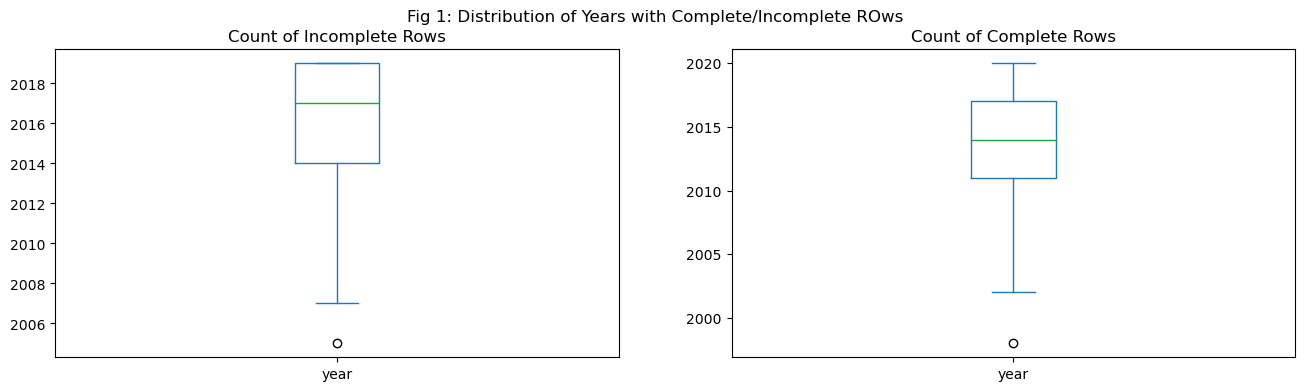

In [177]:
fig, axs = plt.subplots(1,2, figsize=(16,4))

X_train[X_train.isnull().any(axis=1)].plot(y='year', title='Count of Incomplete Rows', kind='box',ax=axs[0])
X_train.dropna().plot(y='year', title='Count of Complete Rows', kind='box',ax=axs[1]) 
plt.suptitle('Fig 1: Distribution of Years with Complete/Incomplete ROws')

In [178]:
# combine missing and non missing rows counts
y1 = X_train[X_train.isnull().any(axis=1)].groupby('year')['mileage'].count()# missing data
y2 = X_train.dropna().groupby('year')['mileage'].count() # not missing data 
# .plot.bar(alpha=.5)

# merge and reset index to flatten headers
df = pd.merge(y1, y2, on='year').reset_index()

# rename column for legend
df.rename(columns={'mileage_x': 'Has NA', 'mileage_y': 'No NA'}, inplace=True)

df.head()

,year,Has NA,No NA
0,2005,1,4
1,2007,1,13
2,2008,1,9
3,2009,1,14
4,2011,1,23


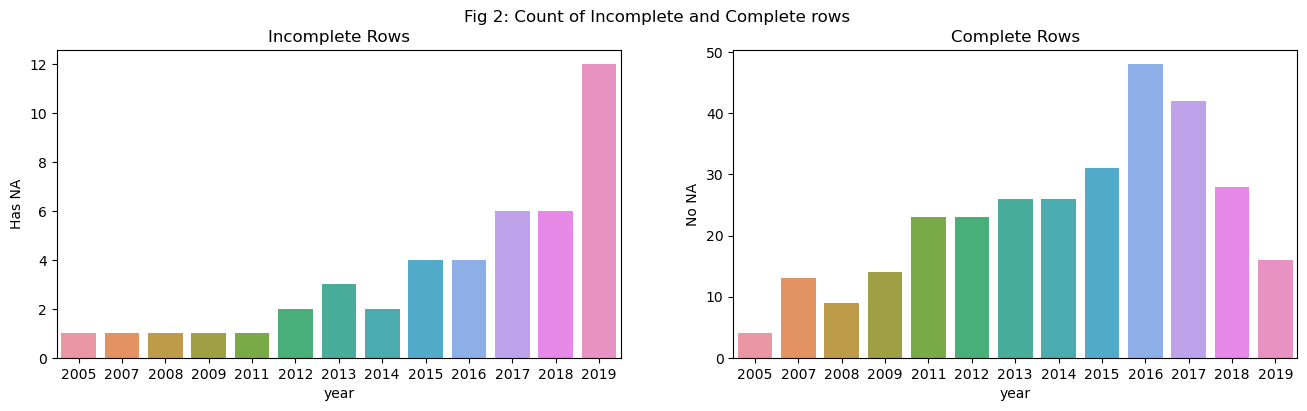

In [179]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
sns.barplot(data=df, x='year', y='Has NA', ax=axs[0]).set_title('Incomplete Rows')
sns.barplot(data=df, x='year', y='No NA', ax=axs[1]).set_title('Complete Rows')
plt.suptitle('Fig 2: Count of Incomplete and Complete rows');

<!-- END QUESTION -->

<a id="part1q2"></a>

## <div class='exercise'><b> Question 2:   Imputation Methods [45 pts]</b></div>

[Return to contents](#contents)

We will try different ways of dealing with missing data. Take care not to overwrite the original `X_train` and `X_test` as we'll want to use them each time we try a new imputation method.

<div class='exercise-r'>

    

**2.1** First, we consider mean imputation:
  - Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_meanimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_meanimp_r2` 
    
**NOTE:** For the sake of consistency, we will used standardized data throughout question 2 (consider why this is necessary for at least some of our models and imputation methods). Note that we are fitting our scaler on *all* the data (train + test).
    
</div>

_Points:_ 12

In [180]:
scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [181]:
X_train_scaled[X_train_scaled.isnull().any(axis=1)].head()

,year,mileage,max_power
1,0.816,-1.508,NaN
4,0.051,-0.876,NaN
12,-0.205,-0.565,NaN
29,1.327,0.783,NaN
31,0.816,-0.803,NaN


In [182]:
# your code here
# Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
imp_mean = SimpleImputer().fit(X_train_scaled)

X_train_scaled = imp_mean.transform(X_train_scaled)
X_test_scaled = imp_mean.transform(X_test_scaled)

# FIll back columns after imputing
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [183]:
X_train_scaled[X_train_scaled.isnull().any(axis=1)].head()

,year,mileage,max_power


In [184]:
linreg_meanimp = LinearRegression().fit(X_train_scaled, y_train)
linreg_y_pred = linreg_meanimp.predict(X_test_scaled)

linreg_meanimp_r2 = r2_score(y_test, linreg_y_pred)
linreg_meanimp_r2

0.18938054143276772

In [185]:
knn_meanimp = KNeighborsRegressor(n_neighbors=2).fit(X_train_scaled, y_train)
knn_y_pred = knn_meanimp.predict(X_test_scaled)

knn_meanimp_r2 = r2_score(y_test, knn_y_pred)
knn_meanimp_r2

0.40078416006676953

In [186]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**2.2** Now, we will impute the data using k-NN regression model and see how it works:
  - Use KNNImputer ($k$=2) to impute both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_knnimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_knnimp_r2` 
</div>

_Points:_ 12

In [187]:
# your code here

#  scale data to reset initial dfs
scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [188]:
# Use KNNImputer to impute the values in the training dataset for both **X_train** and **X_test**. 
k = 2
imp_knn = KNNImputer(n_neighbors=k).fit(X_train_scaled)

X_train_scaled = imp_knn.transform(X_train_scaled)
X_test_scaled = imp_knn.transform(X_test_scaled)

# fill back columns after imputing
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [189]:
# fit linear regression
linreg_knnimp = LinearRegression().fit(X_train_scaled, y_train)
linreg_y_pred = linreg_knnimp.predict(X_test_scaled)

linreg_knnimp_r2 = r2_score(y_test, linreg_y_pred)
print(linreg_knnimp_r2)

# fit knn regression
knn_knnimp = KNeighborsRegressor(n_neighbors=2).fit(X_train_scaled, y_train)
knn_y_pred = knn_knnimp.predict(X_test_scaled)

knn_knnimp_r2 = r2_score(y_test, knn_y_pred)
print(knn_knnimp_r2)

0.20459016028096255
0.6221592514396863


In [190]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

    
**2.3** Now, let's examine the indicator method:
  - For both the training and testing data, create an additional predictor called `has_missing_value` that indicates whether each row has any missing value.
  - Impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_indic_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_indic_r2` 
    
</div>

_Points:_ 12

In [191]:
# your code here
# create aditional predictor 'has_missing_value' to indicate row has missing value (1 is yes, 0 is no)
X_train['has_missing_value'] = X_train.apply(lambda x: 1 if x.isnull().any() else 0, axis=1)
X_test['has_missing_value'] = X_test.apply(lambda x: 1 if x.isnull().any() else 0, axis=1)

# scale train and test data to reset scaled dataset
scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# impute mean of 'max_power' in train dataset for X_train and X_test
# Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
imp_mean = SimpleImputer().fit(X_train_scaled)

X_train_scaled = imp_mean.transform(X_train_scaled)
X_test_scaled = imp_mean.transform(X_test_scaled)

# fill back columns after imputing
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# fit linreg model and store in 'linreg_indic_r2'
linreg_indic = LinearRegression().fit(X_train_scaled, y_train)
linreg_y_pred = linreg_indic.predict(X_test_scaled)

linreg_indic_r2 = r2_score(y_test, linreg_y_pred)
print(linreg_indic_r2)

# fit knn model and store in 'knn_indic_r2'
knn_indic = KNeighborsRegressor(n_neighbors=2).fit(X_train_scaled, y_train)
knn_y_pred = knn_indic.predict(X_test_scaled)

knn_indic_r2 = r2_score(y_test, knn_y_pred)
print(knn_indic_r2)

0.3947819661877332
0.6518542236296969


In [192]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** Compare the $R^2$ values in **2.1** and **2.3**. Does adding an indicator variable help? Do these indicator method results provide any support **for** or **against** a claim that the data is missing completely at random? Why or why not?
    
</div>

_Points:_ 9

In [193]:
# Display your results
pd.DataFrame([
    {'missingness approach': 'mean imputation',
     'linreg test $R^2$': linreg_meanimp_r2,
     'knn test $R^2$': knn_meanimp_r2},
    {'missingness approach': 'knn imputation',
     'linreg test $R^2$': linreg_knnimp_r2,
     'knn test $R^2$': knn_knnimp_r2},
    {'missingness approach': 'missingness indicator + mean imputation',
     'linreg test $R^2$': linreg_indic_r2,
     'knn test $R^2$': knn_indic_r2}, 
]).set_index('missingness approach').reset_index()

,missingness approach,linreg test $R^2$,knn test $R^2$
0,mean imputation,0.189,0.401
1,knn imputation,0.205,0.622
2,missingness indicator + mean imputation,0.395,0.652


Comparing the trend of R^2s for linear regression and KNN, adding an indicator variables lead to the best R^2 scores (missingness indicator + mean imputation > knn imputation > mean imputation). The 0.251 increase in R^2 score when adding a missingness indicator to mean imputation supports for the claim that data is not missing completely at random. Randomly missing data (MCAR) ideally would not really affect the R2 score, as other neighboring datapoints would still allow the model to generalize well. However, non-random missing data (MNAR) - in this case, a lot of missing data in the year 2019 - would introduce biases that ultimately affect the R^2 scores.

<!-- END QUESTION -->

<a id="part2"></a>
    
# PART 2 [45 pts]: Principal Component Analysis

[Return to contents](#contents)

<a id="part2q3"></a>

## <div class='exercise'><b> Question 3: PCA for Regression [35 pts]</b></div>

[Return to contents](#contents)
 

In this question, we will be using a dataset called "Communities and Crime" adapted from [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). The modified dataset contains 122 predictor variables and 1 response variable. All numeric data was normalized into the decimal range 0.00-1.00. Some of the predictor variables are:

- `householdsize`: mean people per household
- `medIncome`: median household income
- `PctHousOccup`: percent of housing occupied
- `RentMedian`: rental housing - median rent
- `PolicReqPerOffic`: total requests for police per police officer

And the response variable is 

- `ViolentCrimesPerPop`: total number of violent crimes per 100K popuation


In [194]:
# Load the datasets
df = pd.read_csv("data/communities_and_crime.csv", index_col = 0)
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,...,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,...,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.10,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.15,0.31,0.40,0.63,0.14,0.06,0.58,0.72,0.65,0.47,0.16,1.00,0.22,0.52,0.10,0.51,0.48,0.39,0.51,0.30,0.29,0.34,0.23,0.13,0.20,...,0.93,0.38,0.05,0.21,0.23,0.30,0.61,0.89,0.15,0.01,0.06,0.12,0.10,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.91,0.5,0.88,0.26,0.49
2,0.25,0.54,0.05,0.71,0.48,0.30,0.42,0.48,0.28,0.32,0.26,1.00,0.33,0.55,0.37,0.37,0.39,0.64,0.44,0.32,0.29,0.32,0.23,0.17,0.17,...,0.96,0.12,0.05,0.11,0.35,0.08,0.80,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.46,0.05,0.09,0.05,0.88,0.5,0.76,0.13,0.34
3,1.00,0.42,0.47,0.59,0.12,0.05,0.41,0.53,0.34,0.33,1.00,0.99,0.28,0.62,0.16,0.36,0.40,0.30,0.45,0.29,0.30,0.35,0.21,0.20,0.33,...,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.70,0.45,0.03,0.05,0.33,0.13,0.57,1.00,1.00,0.07,0.15,1.00,0.35,0.73,0.0,0.31,0.21,0.69
4,0.11,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,1.00,0.22,0.52,0.44,0.49,0.56,0.41,0.39,0.25,0.25,0.25,0.16,0.07,0.20,...,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0.00,0.00,0.00,0.00,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09,0.63


In [195]:
# Separate predictors and response
X, y = df.drop(columns=['ViolentCrimesPerPop']), df['ViolentCrimesPerPop']
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="part2q3solution"></a>
## Question 3: Solutions 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Compute the correlation matrix for the predictor variables in the training data (DO NOT print the entire matrix). Which pairs of distinct predictor variables have correlation greater than 0.99 or less than -0.99? 
    
Store these pairs in a dictionary called `high_corr` where the keys are tuples corresponding to the names of the pair of predictors and the values are the correlation between each pair.
    
</div>

_Points:_ 6

In [196]:
# correlation matric for train data
d = dict()

corr = X_train.corr()
# corr
# {(corr.columns[i], corr.columns[j]): }
for i, j in zip(*np.where(np.abs(corr.values) > 0.99)):
    if i < j:
        d[(corr.columns[i], corr.columns[j])] = corr.values[i][j]

In [197]:
# your code here
high_corr = d
print("The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:")
display(high_corr)

The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:


{('population', 'numbUrban'): 0.9997647561886096,
 ('PctRecentImmig', 'PctRecImmig5'): 0.9920034327871089,
 ('PctRecImmig5', 'PctRecImmig8'): 0.9963359613654262,
 ('PctRecImmig5', 'PctRecImmig10'): 0.9900961766413996,
 ('PctRecImmig8', 'PctRecImmig10'): 0.9965871515033231,
 ('OwnOccLowQuart', 'OwnOccMedVal'): 0.9917227618576423,
 ('RentMedian', 'MedRent'): 0.9930215184921779,
 ('LemasSwornFT', 'LemasSwFTFieldOps'): -0.990313653958998,
 ('LemasSwFTPerPop', 'PolicPerPop'): 0.9999911313418828}

In [198]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Fit a linear regression model on the **unscaled** training data **using all available predictors**. Store the train and test $R^2$ scores in `linreg_train_r2` and `linreg_test_r2` respectively. Interpret your results.
    
</div>

_Points:_ 6

Although the model with unscaled data explains ~84.61% of the training data, it underperforms on the test data, predicting only ~21.86% of the data. The observation of train R^2 > test R^2 suggest that the model is overfitted, or worse case, does not fulfill the assumptions of linear regression.

In [199]:
# your code here
# Fit linear regression
linreg = LinearRegression().fit(X_train, y_train)

# predict y-values on train and test
linreg_y_train_pred = linreg.predict(X_train)
linreg_y_test_pred = linreg.predict(X_test)

# get r2 values
linreg_train_r2 = r2_score(y_train, linreg_y_train_pred)
linreg_test_r2 = r2_score(y_test, linreg_y_test_pred)

print(f"linear regression train R^2: {linreg_train_r2:.4f}")
print(f"linear regression test R^2: {linreg_test_r2:.4f}")

linear regression train R^2: 0.8461
linear regression test R^2: 0.2186


In [200]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>


**3.3.1** Standardize both **X_train** and **X_test**, *fitting the scaler on all the data*, and for each number of components $k$ in $k \in \{1,2,3,4,5,6,8,10,12,15,20\}$: 

  - Fit the PCA transformation with n_components = $k$ on the standardized **X_train**.
    
  - Apply the PCA transformation to the standardized **X_train**.
    
  - Use scikit-learn's cross_validate(...) to perform a 10-fold cross validation for a linear regression model on the transformed training data. 
    
  Plot the mean validation MSE for each $k$. Store the best $k$ based on the mean validation MSE as `best_k`.
    
</div>

_Points:_ 14

In [201]:
# standardize X_train and X_test, fitting scaler on all data to get everything within a range
scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [202]:
# loop thru k in ks
ks = [1,2,3,4,5,6,8,10,12,15,20]
mse_list = []

for k in ks:
    #  fit PCA w/ n=k
    pca = PCA(n_components=k).fit(X_train_scaled)
    pca_x = pca.transform(X_train_scaled)

    # fit linear regression
    linreg_pca = LinearRegression(fit_intercept=True)
    linreg_pca.fit(pca_x, y_train)

    # crossvalidate x10
    mse_score = cross_validate(
        linreg_pca, 
        pca_x, 
        y_train,
        cv=10, 
        scoring="neg_mean_squared_error",
        return_train_score=True,
    )
    mean_mse = np.mean(-mse_score["test_score"])
    mse_list.append(mean_mse)

mse_list

[0.03768384711919074,
 0.03798669286086742,
 0.03531194529363668,
 0.03553891706312588,
 0.03422362558192425,
 0.034150215216990104,
 0.029773058350708554,
 0.030435072460648898,
 0.030939454441469828,
 0.03149756574141432,
 0.03209255368285273]

In [203]:
# your code here
best_idx = np.argmin(mse_list)
best_mse = mse_list[best_idx]
best_k = ks[best_idx]
print(f"The best k is {best_k} with score of {best_mse}.")

The best k is 8 with score of 0.029773058350708554.


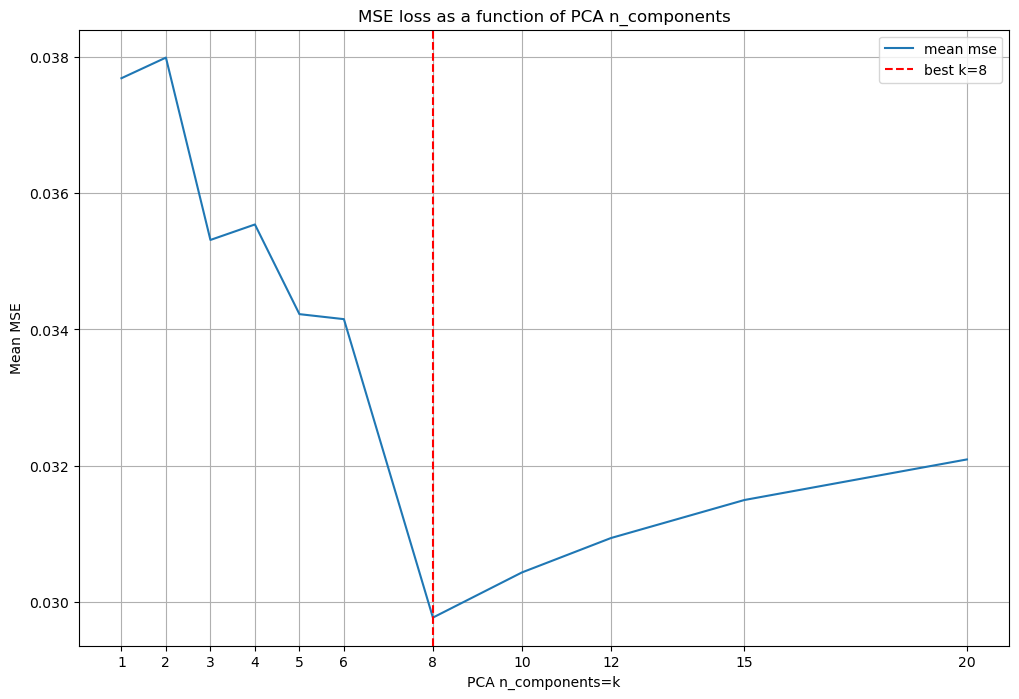

In [204]:
# plot mean validation for best k

plt.figure(figsize=(12, 8))
plt.plot(ks, mse_list, label='mean mse')
# plt.plot(degree, val_mses, label='validation')
# plt.yscale("log")
plt.xticks(ticks=ks, labels=ks)
plt.axvline(best_k, c='r', ls='--', label=rf'best k={best_k}')
plt.xlabel(r'PCA n_components=k')
plt.ylabel('Mean MSE')
plt.title('MSE loss as a function of PCA n_components')
plt.legend();
plt.grid()
plt.show()

In [205]:
grader.check("q3.3.1")

q3.3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>
    

**3.3.2** Now let's compute the $R^2$ value on the testing data:
  - Fit the PCA transformation on the standardized **X_train** with n_components equal to the best $k$ above.
  - Apply the PCA transformation to the standardized **X_train** and the standardized **X_test**. 
  - Fit a linear regression model to the PCA-transformed components. Store the train and test $R^2$ scores in `pcr_train_r2` and `pcr_test_r2` respectively.
    
</div>

_Points:_ 6

In [206]:
#  fit PCA w/ n=k
pca = PCA(n_components=best_k).fit(X_train_scaled)
pca_x_train = pca.transform(X_train_scaled)
pca_x_test = pca.transform(X_test_scaled)

# fit linear regression
pcr = LinearRegression(fit_intercept=True)
pcr.fit(pca_x_train, y_train)

# predict y-values on train and test
pcr_y_train_pred = pcr.predict(pca_x_train)
pcr_y_test_pred = pcr.predict(pca_x_test)

# # get r2 values
# linreg_train_r2 = r2_score(y_train, pcr_y_train_pred)
# linreg_test_r2 = r2_score(y_test, pcr_y_test_pred)

In [207]:
# your code here
# get r2 values
pcr_train_r2 = r2_score(y_train, pcr_y_train_pred)
pcr_test_r2 = r2_score(y_test, pcr_y_test_pred)
print(f"PCR train R^2: {pcr_train_r2:.4f}")
print(f"PCR test R^2: {pcr_test_r2:.4f}")

PCR train R^2: 0.6377
PCR test R^2: 0.6858


In [208]:
grader.check("q3.3.2")

q3.3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.4** Compare the $R^2$ value obtained from **3.2** (original predictors) and **3.3.2** (PCR). Provide an explanation for the observed difference in these results.
    
</div>

_Points:_ 3

In [209]:
# Display your results
pd.DataFrame([
    {'model': 'linear regression (original predictors)',
     'train $R^2$': linreg_train_r2,
     'test $R^2$': linreg_test_r2},
    {'model': f'PCR (k={best_k})',
     'train $R^2$': pcr_train_r2,
     'test $R^2$': pcr_test_r2},
]).set_index('model')

,train $R^2$,test $R^2$
model,,
linear regression (original predictors),0.846,0.219
PCR (k=8),0.638,0.686


Model 3.2 (linear regression (original predictors)) has train R^2 > test R^2, suggesting that the model explains a lot of the training data, but is poor at generalizing test data. This could be due to unresolved multicollinearity - e.g. the 9 predictor relationships with |corr.value| > 0.99 in Question 3.1. Multicollinearity violates the assumptions for linear regression, coefficient estimates can be unreliable, and can lead to misleading test significance scores (e.g. r^2, p-value).

For Model 3.3.2 (PCR (k=8)), it's train R^2 is worse than Model 3.2's train R^2, but it has a slightly better test r^2 of 0.686. The PCA step 'chooses' and weighs combination of a group of correlated variables to maximize variance, and solves the dataset's multicollinearity issues. With no multicollineraity in the model, the predictive strength of the model then improves.

<!-- END QUESTION -->

<a id="part2q4"></a>

## <div class='exercise'><b> Question 4: Visualizing Transformed Data [10 pts]</b></div>

[Return to contents](#contents)

In this question, we will be using a dataset called "Better Life Index" adapted from [Organisation for Economic Co-operation and Development](https://stats.oecd.org/). The modified dataset contains 24 numerical variables and 1 categorical variable. The categorical variable `Country` is the name of the country. Some of the numerical variables include:

- `Dwellings without basic facilities`
- `Housing expenditure`
- `Rooms per person`
- `Household net adjusted disposable income`
- `Household net financial wealth`
- ...

In [210]:
# Load and inspect the datasets
df = pd.read_csv("data/OECD_well-being.csv", index_col = 0)
print('df shape:', df.shape)
df.head()

df shape: (38, 25)


,Country,Dwellings without basic facilities,Housing expenditure,Rooms per person,Household net adjusted disposable income,Household net financial wealth,Labour market insecurity,Employment rate,Long-term unemployment rate,Personal earnings,Quality of support network,Educational attainment,Student skills,Years in education,Air pollution,Water quality,Stakeholder engagement for developing regulations,Voter turnout,Life expectancy,Self-reported health,Life satisfaction,Feeling safe walking alone at night,Homicide rate,Employees working very long hours,Time devoted to leisure and personal care
0,Australia,1.1,20,2.3,33417,57462,4.3,72,1.36,52063,94,80,502,21.2,5,92,2.7,91,82.5,85,7.3,63.6,1.0,13.20,14.35
1,Austria,1.0,21,1.6,32544,59574,2.7,72,1.94,48295,92,85,492,17.1,16,93,1.3,75,81.3,70,7.0,80.7,0.4,6.78,14.55
2,Belgium,2.3,21,2.2,29968,104084,4.8,62,3.98,49587,92,75,503,18.2,15,84,2.2,89,81.1,75,6.9,70.7,1.0,4.31,15.77
3,Canada,0.2,22,2.5,29850,85758,3.9,73,0.81,48403,93,91,523,16.7,7,91,3.0,68,81.5,88,7.3,80.9,1.4,3.73,14.41
4,Chile,9.4,18,1.9,16588,21409,8.1,62,2.02,28434,84,65,443,17.3,16,69,1.5,49,79.1,57,6.7,51.1,4.5,10.06,14.90


In [211]:
# Separate predictors and response
country, X = df['Country'], df.drop(columns='Country').values
# country, X

<div class='exercise-r'>

**4.1** Standardize **X** and apply a PCA transformation with n_components = 2 to your standardized data. Save the transformed data as `X_transformed`.
    
</div>


_Points:_ 2

In [212]:
# standardize X_train and X_test, fitting scaler on all data to get everything within a range
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Add back column names lost during scaling
X_scaled = pd.DataFrame(X_scaled, columns=df.columns[1:])
X_scaled.head(5)

,Dwellings without basic facilities,Housing expenditure,Rooms per person,Household net adjusted disposable income,Household net financial wealth,Labour market insecurity,Employment rate,Long-term unemployment rate,Personal earnings,Quality of support network,Educational attainment,Student skills,Years in education,Air pollution,Water quality,Stakeholder engagement for developing regulations,Voter turnout,Life expectancy,Self-reported health,Life satisfaction,Feeling safe walking alone at night,Homicide rate,Employees working very long hours,Time devoted to leisure and personal care
0,-0.359,-0.376,1.412,1.048,0.212,-0.233,0.526,-0.501,1.040,0.877,0.175,0.461,2.783,-1.442,0.908,0.946,1.821,0.640,1.273,1.007,-0.387,-0.358,0.582,-0.649
1,-0.374,0.044,-0.090,0.938,0.267,-0.550,0.526,-0.343,0.772,0.435,0.492,0.158,-0.201,0.448,1.001,-1.092,0.432,0.380,0.185,0.615,0.927,-0.470,-0.253,-0.381
2,-0.176,0.044,1.197,0.613,1.433,-0.134,-0.708,0.213,0.864,0.435,-0.142,0.491,0.599,0.276,0.162,0.218,1.647,0.337,0.548,0.484,0.159,-0.358,-0.574,1.255
3,-0.496,0.464,1.841,0.598,0.953,-0.312,0.649,-0.651,0.780,0.656,0.872,1.096,-0.492,-1.099,0.815,1.383,-0.176,0.424,1.490,1.007,0.942,-0.284,-0.649,-0.569
4,0.908,-1.215,0.553,-1.077,-0.732,0.520,-0.708,-0.321,-0.640,-1.329,-0.775,-1.323,-0.056,0.448,-1.237,-0.801,-1.825,-0.095,-0.758,0.223,-1.347,0.290,0.174,0.088


In [213]:
#  fit PCA w/ n=2
pca = PCA(n_components=2).fit(X_scaled)

X_transformed = pca.transform(X_scaled)

In [214]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Make a scatter plot for the transformed data, where the x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component. The plot should state the amount of variance explained by each component. 

Label each point by its corresponding country name. Do you observe any pattern in the scatter plot? Be specific and explain.
    
</div>

_Points:_ 6

Developed countries are grouped together on the left part of the plot - suggesting that these countries are similar in terms of the "Better Life index". Russia and Eastern European countries like Estonia and Czech Republic are also clustered together - is this due to their geopolitical influences on the nation's "Better Life Index" features? South Africa is an outlier on the far upper right corner, perhaps due to it being having poor(est?) life conditions or unfavorable "Better Life Index" features compared to other countries. South Africa, Brazil, Turkey, and Mexico's datapoints suggest a pattern of developing nations - they also happen to be industrial nations, whose economies are based in manufacturing and export of goods (food, cars, etc). Another interesting cluster are the Asian countries Japan and Korea at the bottom of the plot.

In [215]:
pca_x = X_transformed
pca.explained_variance_

array([10.47691758,  2.57122146])

In [216]:
pca_x.shape

(38, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


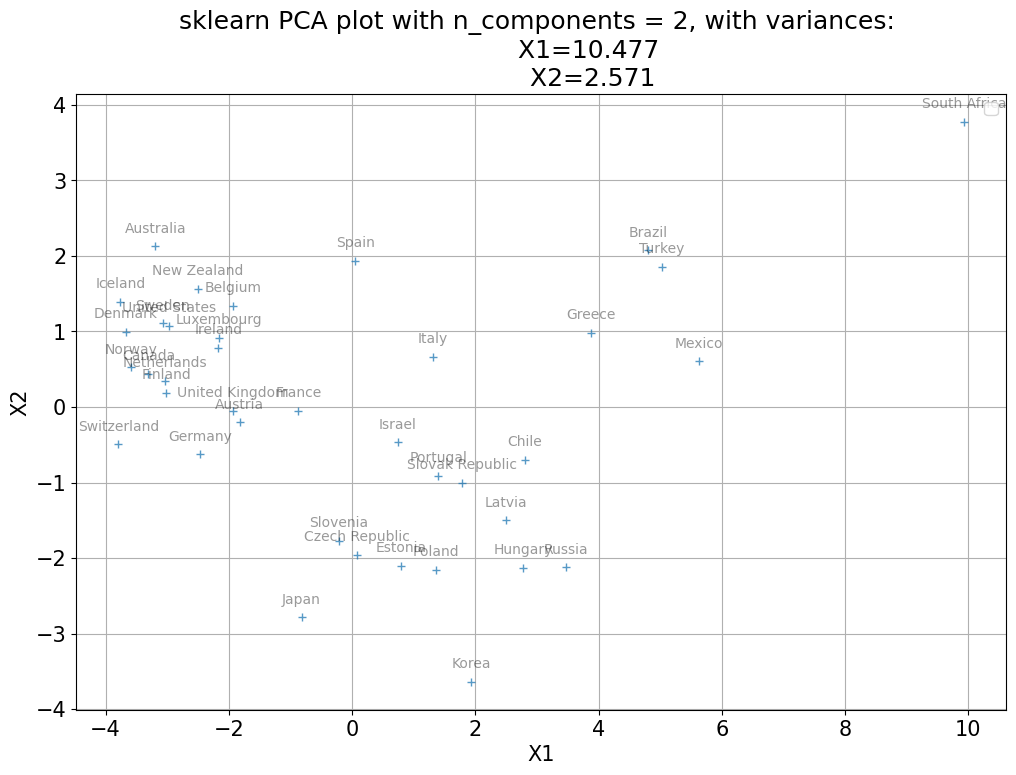

In [220]:
# Plotting training and testing dataset with regression line
plt.figure(figsize=(12,8))

plt.plot(pca_x[:,0], pca_x[:,1], '+', alpha=0.75)

# label each point
for x, y, label in zip(pca_x[:,0], pca_x[:,1], country):
    plt.annotate(label,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center', alpha=0.4)

plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('X1', fontsize=15)
plt.ylabel('X2', fontsize=15)
plt.title(f'sklearn PCA plot with n_components = 2, with variances: \n \
            X1={pca.explained_variance_[0]:0.3f} \n \
            X2={pca.explained_variance_[1]:0.3f}', fontsize=18)
plt.grid()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** In question 3, where we also used PCA, we had a training and a test set. In question 4 we did not split the data. Explain why.
    
</div>

_Points:_ 2

PCA had different purposes in both questions. 

In Question 3, PCA identified the best features while removing multicollinear features in both train and test data, resulting in the best_k (n_components). The dataset transformed by PCA with best k allowed for improved linear regression model predictive power.

In Question 4, we did not split as there is not linear regression model required. PCA, as an unsupervised learning algoritm, learns (.fit()) the structure of the entire dataset and reduces it's dimensionality (.transforms()) into a 2D space, which we then plotted. The caveat of dimensional reduction is that the relationships between the variables are less interpretable.

<!-- END QUESTION -->

**This concludes HW4. Thank you!**

[Return to contents](#contents)